In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import altair as alt

In [2]:
%matplotlib inline

In [30]:
# Import call data and report data and create df's

data = pd.read_csv("/Users/Stacy/Documents/WebDevelopment/projects/SPD/sexualAssault_datasets/2010-2018_sexcrimes_violentcrimes.csv", index_col="CAD Event Number")
data = pd.DataFrame(data)

report_data = pd.read_csv('/Users/Stacy/Documents/WebDevelopment/projects/SPD/sexualAssault_datasets/2010-2018_Crime_Data.csv', index_col='Report Number')
report_data = pd.DataFrame(report_data)

In [31]:
# Rename columns to be pythonic

data.columns = ['event_clearing', 'call_type', 'priority', 
                'initial_call_type', 'final_call_type', 'original_time_queued',
               'arrived_time', 'precinct', 'sector', 'beat']

report_data.columns = ['event_date', 'event_time', 'report_date',
                       'report_time','crime_subcategory', 'primary_offense_descript',
                       'precinct', 'sector', 'beat', 'neighborhood']

In [32]:
# ID all calls cancelled by dispatch

cancelled_calls = data[data.event_clearing.str.contains("CANCELLED")]

# Delete rows with cxl'd calls

data = data[data.event_clearing != 'RESPONDING UNIT(S) CANCELLED BY RADIO']
data = data[data.event_clearing != 'DUPLICATED OR CANCELLED BY RADIO']

#### Clean time values

In [33]:
report_data.dtypes

event_date                  object
event_time                   int64
report_date                 object
report_time                  int64
crime_subcategory           object
primary_offense_descript    object
precinct                    object
sector                      object
beat                        object
neighborhood                object
dtype: object

In [34]:
report_data.head()

,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct,sector,beat,neighborhood
Report Number,,,,,,,,,,
20100000100029,03/27/2010,239,03/27/2010,310,NARCOTIC,NARC-POSSESS-HALLUCINOGEN,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000100052,03/27/2010,1,03/27/2010,501,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
20100000100057,03/27/2010,348,03/27/2010,402,DUI,DUI-LIQUOR,UNKNOWN,NaN,NaN,UNKNOWN
20100000100076,03/27/2010,300,03/27/2010,450,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B3,WALLINGFORD
20100000100104,03/27/2010,508,03/27/2010,508,DUI,DUI-DRUGS,EAST,E,E1,CAPITOL HILL


In [36]:
# Change event_date and report_date to datetime
report_data['event_date'] = pd.to_datetime(report_data.event_date)
report_data['report_date'] = pd.to_datetime(report_data.report_date)

# Change event_time and report_time to datetime
report_data['event_time'] = pd.to_datetime(report_data.event_time, unit='s')
report_data['report_time'] = pd.to_datetime(report_data.report_time, unit='s')

# report_data['event_time'] = pd.to_datetime(report_data.event_time, format='%H:%M').dt.time
# report_data['report_time'] = pd.to_datetime(report_data.report_time, format='%H:%M').dt.time




In [39]:
# Change original_time_queued to datetime
data['original_time_queued'] = pd.to_datetime(data.original_time_queued)

# Change arrived_time to datetime
data['arrived_time'] = pd.to_datetime(data.arrived_time, format='%b %d %Y %I:%M:%S:%f%p')

# Add time delta between original_time_queued and arrived_time
data['time_delta'] = ((data.arrived_time - data.original_time_queued)/np.timedelta64(1, 's')).astype(int)

In [40]:
# Add columns for arrived year and month
data['year'] = data.arrived_time.dt.year
data['month'] = data.arrived_time.dt.month

# Where arrive_time year = 1900, change data.year and data.month to original_time_queued year
mask = data.year < 1901
column_name_year = 'year'
column_name_month = 'month'
data.loc[mask, column_name_year] = data.original_time_queued.dt.year
data.loc[mask, column_name_month] = data.original_time_queued.dt.month

In [47]:
report_data.head()

,event_date,event_time,report_date,report_time,crime_subcategory,primary_offense_descript,precinct,sector,beat,neighborhood
Report Number,,,,,,,,,,
20100000100029,2010-03-27,1970-01-01 00:03:59,2010-03-27,1970-01-01 00:05:10,NARCOTIC,NARC-POSSESS-HALLUCINOGEN,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
20100000100052,2010-03-27,1970-01-01 00:00:01,2010-03-27,1970-01-01 00:08:21,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
20100000100057,2010-03-27,1970-01-01 00:05:48,2010-03-27,1970-01-01 00:06:42,DUI,DUI-LIQUOR,UNKNOWN,NaN,NaN,UNKNOWN
20100000100076,2010-03-27,1970-01-01 00:05:00,2010-03-27,1970-01-01 00:07:30,ROBBERY-STREET,ROBBERY-STREET-BODYFORCE,NORTH,B,B3,WALLINGFORD
20100000100104,2010-03-27,1970-01-01 00:08:28,2010-03-27,1970-01-01 00:08:28,DUI,DUI-DRUGS,EAST,E,E1,CAPITOL HILL


#### Define terms

In [42]:
# Define TRU initial call types
TRU_call_types = [
    'TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS)',
    'TRU - RAPE',
    'TRU - LEWD CONDUCT',
    'TRU - CHILD ABUSED, NEGLECTED',
    'TRU - THREATS',
    'TRU - ROBBERY',
    'TRU - ASLT - MOLESTED ADULT (GROPED, FONDLED, ETC)',
    'TRU - HARASSMENT',
    'TRU - SEX IN PUBLIC',
    'TRU - THEFT',
    'TRU - FOLLOW UP',
    'TRU - MVC - HIT AND RUN',
    'TRU - LURING',
    'TRU - FORGERY/CHKS/BUNCO/SCAMS/ID THEFT',
    'TRU - SUSPICIOUS CIRCUMSTANCES']

In [43]:
# Define terms that ID which crime_type

# Define terms that ID rape CFS
rape_terms = 'Stranger|Acquaintance'
rape_call_types = [
    'Acquaintance Rape',
    'Stranger Rape']
    #'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    #'--RAPE - UNKNOWN SUSPECT (STRANGER)']

# Define terms that ID sex crimes
sex_crime_terms = 'CSEC|Lewd|Molesting|Stranger|Acquaintance'
sex_crime_call_types = [
    'Lewd Conduct',
    'Acquaintance Rape',
    'Stranger Rape',
    'Molesting',
    'CSEC']
   # '--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT',
    #'--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    #'--RAPE - UNKNOWN SUSPECT (STRANGER)',
    #'--SEX OFFENSES (RAPE) - MOLESTING',
    #'--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)']

# Define terms that ID other violent crimes
violent_crime_terms = 'Kidnap|Homicide|Shooting|Assault|Robbery'
violent_crime_call_types = [
    '--ASSAULTS - FIREARM INVOLVED',
    '--ROBBERY - ARMED',
    '--HOMICIDE',
    '--KIDNAP - GENERAL',
    '--DRIVE BY SHOOTING - NO INJURIES']

In [44]:
# Replace final_call_type values to english
# DRY this. oof.

# Seriously. Look at this. oof.

data['final_call_type'] = data['final_call_type'].replace("--HOMICIDE", "Homicide")
data['final_call_type'] = data['final_call_type'].replace("--ASSAULTS - FIREARM INVOLVED", "Assault w/ Firearm")
data['final_call_type'] = data['final_call_type'].replace("--ROBBERY - ARMED", "Armed Robbery")
data['final_call_type'] = data['final_call_type'].replace("--KIDNAP - GENERAL", "Kidnap")
data['final_call_type'] = data['final_call_type'].replace("--DRIVE BY SHOOTING - NO INJURIES", "Drive-by Shooting")
data['final_call_type'] = data['final_call_type'].replace("--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT", "Lewd Conduct")
data['final_call_type'] = data['final_call_type'].replace("--RAPE - KNOWN SUSPECT (ACQUAINTANCE)", "Acquaintance Rape")
data['final_call_type'] = data['final_call_type'].replace("--RAPE - UNKNOWN SUSPECT (STRANGER)", "Stranger Rape")
data['final_call_type'] = data['final_call_type'].replace("--SEX OFFENSES (RAPE) - MOLESTING", "Molesting")
data['final_call_type'] = data['final_call_type'].replace("--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)", "CSEC")

# Replace precinct names with lowercase
data['precinct'] = data['precinct'].replace('NORTH', 'North')
data['precinct'] = data['precinct'].replace('EAST', 'East')
data['precinct'] = data['precinct'].replace('SOUTH', 'South')
data['precinct'] = data['precinct'].replace('WEST', 'West')
data['precinct'] = data['precinct'].replace('SOUTHWEST', 'Southwest')
data['precinct'] = data['precinct'].replace('UNKNOWN', 'Unknown')

In [45]:
# Define clearing codes for is_arrest

arrest_cc = ['PHYSICAL ARREST MADE']

#### Add columns for is_arrest, is_TRU, crime_type

In [48]:
# Add column identifying if there was an arrest
data['is_arrest'] = np.where(data['event_clearing'].isin(arrest_cc), 'yes', 'no')

# Add column identifying if this was A TRU call
data['is_TRU'] = np.where(data['initial_call_type'].isin(TRU_call_types), 'yes', 'no')

In [49]:
# Add crime_type for each call type as a violent crime, sex crime or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)
is_lewd_conduct = data['final_call_type'].str.contains("Lewd")
is_arrest_mask = data['is_arrest'] == "yes"
is_tru_mask = data['is_TRU'] == "yes"

data['crime_type'] = np.where(data['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(data['final_call_type'].isin(sex_crime_call_types),
                                          'other sex crime', 'violent crime')))

## 1. 2018 Sees increase in reports of sex crimes


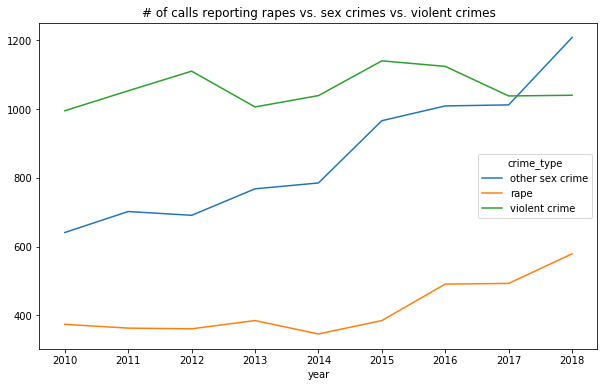

In [50]:
# Compare number of rape calls, non-rape sex crime calls, and violent crime calls by year

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6),
    title="# of calls reporting rapes vs. sex crimes vs. violent crimes")

Between 2010 and 2018 there has been a general increase in the number of calls each year for lewd conduct. During this time period, number of lewd conduct calls in the North, East and West precincts have steadily increased. In the same time period, these calls in the South and Southwest precincts have remained mostly flat. 

In 2015 and 2018 there were marked increases in these calls in the North, East and West precincts.

## 2. Arrests for VC have increased


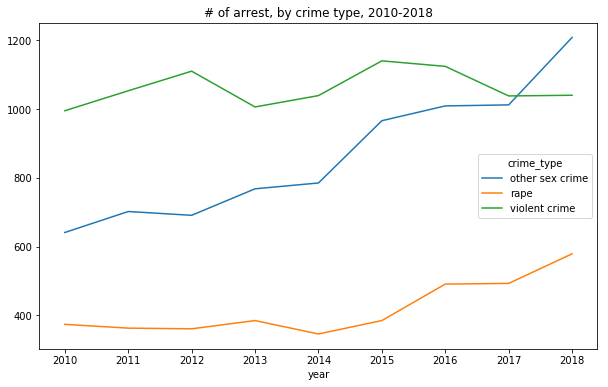

In [51]:
# Create df for all calls with an arrest

arrest_df = data['is_arrest'] == "yes"

# Plot the count of calls with an arrest, by year and crime type

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of arrest, by crime type, 2010-2018")


In [52]:
# Calculate arrest percentages by crime type for each year
arrest_percent_by_yr = pd.crosstab([data.crime_type, data.year],data.is_arrest,
                         normalize = 'index')

# Multiply all percentages by 100 for graphing. 
arrest_percent_by_yr *= 100

# Flatten df
arrest_percent_by_yr.reset_index(inplace=True)

# Remove "no" percentages
arrest_percent_by_yr = arrest_percent_by_yr.drop('no', axis=1)

In [53]:
# Separate data by crime type for visualization

vc_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("violent")]
rape_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("rape")]
other_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("other")]

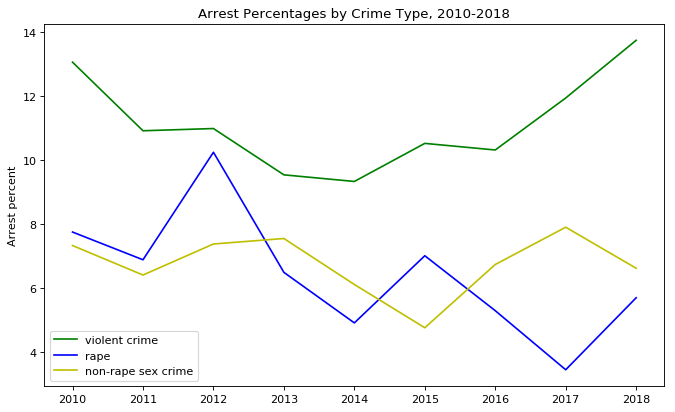

In [54]:
# Plot arrests percentges by year.

plt.figure(figsize=(10,6), dpi= 80)
plt.plot(vc_arr_by_yr.year, vc_arr_by_yr.yes, color='g', label='violent crime')
plt.plot(rape_arr_by_yr.year, rape_arr_by_yr.yes, color='b', label='rape')
plt.plot(other_arr_by_yr.year, other_arr_by_yr.yes, color='y', label='non-rape sex crime')

plt.ylabel('Arrest percent')
plt.title('Arrest Percentages by Crime Type, 2010-2018')
plt.legend()

plt.show()

## 3. TRU Calls


In [55]:
# Create crosstab to view % all TRU calls by crime type

percentage_tru_calls = pd.crosstab(data.final_call_type,data.is_TRU,
                          normalize = 'index').rename_axis(None)



percentage_tru_calls

is_TRU,no,yes
Acquaintance Rape,0.975972,0.024028
Armed Robbery,0.999149,0.000851
Assault w/ Firearm,0.990256,0.009744
CSEC,0.980769,0.019231
Drive-by Shooting,0.999125,0.000875
Homicide,1.000000,0.000000
Kidnap,0.989899,0.010101
Lewd Conduct,0.990761,0.009239
Molesting,0.971763,0.028237
Stranger Rape,0.986559,0.013441


Sex crimes where there is a victim, are initially sent to TRU at higher rates than other violent crimes. For the nine years of police calls examined, non-sex-related violent crimes sent to TRU averaged less than 1% of the time. In the same time period, 2.4% of calls reporting acquaintance rape and 2.8% of molestation were sent to TRU.

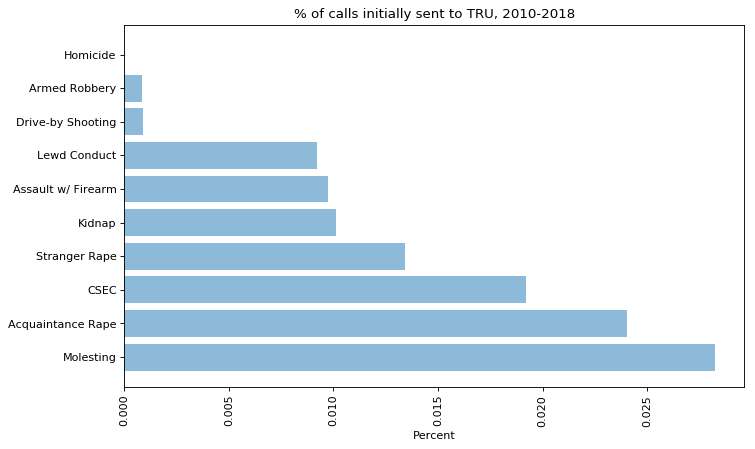

In [56]:
# Plot TRU call percentages as bar graph. 

percentage_tru_sorted = percentage_tru_calls.sort_values('yes',ascending=False)

plt.figure(figsize=(10,6), dpi= 80)
plt.barh(percentage_tru_sorted.index, percentage_tru_sorted.yes, align='center', alpha=0.5)
plt.xlabel('Percent')
plt.title('% of calls initially sent to TRU, 2010-2018')
plt.xticks(rotation=90)

plt.show()

An average of 2.8% of the calls reporting molesting were sent to TRU. 

Even though the overall number of rape calls initially sent to the Telephone Reporting Unit is low, it still means that 75 people called the Seattle Police Department to report a rape and were directed to the same police unit that would handle a call reporting a bicycle that was stolen two years ago.

Between 2010 and 2018, 55 acquaintance rape calls, 20 stranger rape calls and 41 molesting calls were referred to TRU.

**Insert viz showing number of rape and molesting calls sent to TRU**

tutorial: https://pudding.cool/process/flexbox-layout/

In [88]:
# Sandbox to confirm number of TRU molesting and rape calls

data_tru_df = data[is_tru_mask]
# data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Molesting")]
#data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Acquaintance")]
#data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("Stranger")]
data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains('Rape')]

data_tru_df.head()

,event_clearing,call_type,priority,initial_call_type,final_call_type,original_time_queued,arrived_time,precinct,sector,beat,time_delta,year,month,is_arrest,is_TRU,crime_type
CAD Event Number,,,,,,,,,,,,,,,,
2010000135469,RADIO BROADCAST AND CLEAR,"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Acquaintance Rape,2010-04-26 10:00:35,2010-04-26 10:33:27,North,NORA,N3,1972,2010,4,no,yes,rape
2010000187117,RADIO BROADCAST AND CLEAR,"TELEPHONE OTHER, NOT 911",5,TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS),Stranger Rape,2010-06-04 14:15:48,2010-06-04 15:05:24,West,QUEEN,Q3,2976,2010,6,no,yes,rape
2010000193566,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Acquaintance Rape,2010-06-09 08:28:18,2010-06-09 09:11:39,East,CHARLIE,C1,2601,2010,6,no,yes,rape
2010000257863,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Stranger Rape,2010-07-26 15:08:29,2010-07-26 15:09:39,Southwest,WILLIAM,W2,70,2010,7,no,yes,rape
2010000339209,REPORT WRITTEN (NO ARREST),"TELEPHONE OTHER, NOT 911",5,TRU - RAPE,Stranger Rape,2010-09-28 10:13:59,2010-09-28 11:54:04,North,BOY,B1,6005,2010,9,no,yes,rape


In [89]:
data_tru_df = pd.crosstab(data_tru_df.year, columns=[data_tru_df.final_call_type, data_tru_df.event_clearing])
data_tru_df = data_tru_df.stack().reset_index()
# data_tru_df = data_tru_df.rename(columns={'Lewd Conduct':'lewd_conduct'})
data_tru_df

final_call_type,year,event_clearing,Acquaintance Rape,Stranger Rape
0,2010,ASSISTANCE RENDERED,0,0.0
1,2010,NON-CRIMINAL REFERRAL,0,NaN
2,2010,RADIO BROADCAST AND CLEAR,1,1.0
3,2010,REPORT WRITTEN (NO ARREST),1,2.0
4,2010,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,0,0.0
5,2011,ASSISTANCE RENDERED,1,0.0
6,2011,NON-CRIMINAL REFERRAL,2,NaN
7,2011,RADIO BROADCAST AND CLEAR,0,0.0
8,2011,REPORT WRITTEN (NO ARREST),0,1.0
9,2011,UNABLE TO LOCATE INCIDENT OR COMPLAINANT,0,0.0


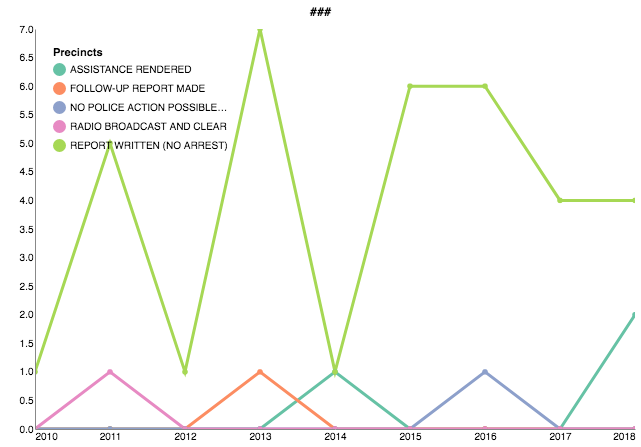

In [87]:
# USE
# Chart number of calls reporting each final call type

alt.Chart(data_tru_df).mark_line(point=True).encode(
    x=alt.X('year',axis=alt.Axis(format='Y', title='', ticks=False)),
    y=alt.Y('Molesting', axis=alt.Axis(title='', ticks=False)),
#     tooltip=('precinct', 'year','lewd_conduct'),
    color=alt.Color(
        'event_clearing',
        legend=alt.Legend(
            title='Precincts',
            orient='top-left'
        ), scale=alt.Scale(
            scheme='set2'
        ))
).properties(
    title='###',
    width=600,
    height=400
).configure_axis(
    grid=False
).configure_line(
    strokeWidth=3
).configure_view(
    strokeWidth=0
).interactive()

# To do: edit tooltips to remove labels and add "calls" after count. Change axis font label formatting

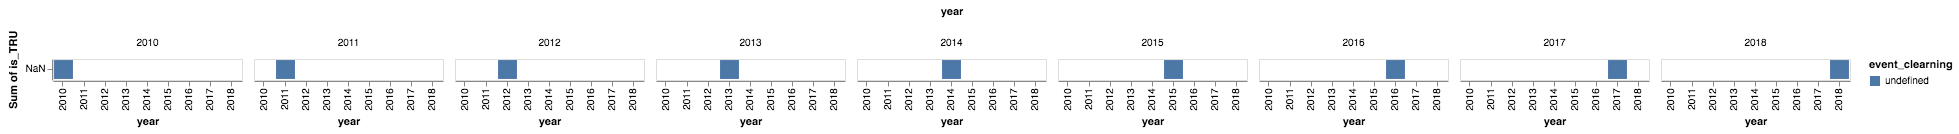

In [66]:

alt.Chart(data_tru_df).mark_bar().encode(
    x='year:O',
    y='sum(is_TRU)',
    color='event_clearning:N',
    column='year:N'
)


In [75]:
data_tru_df = data_tru_df.groupby('event_clearing')
# lewd_call_total_df = lewd_call_total_df.stack().reset_index()
# lewd_call_total_df = lewd_call_total_df.rename(columns={0: 'type_count'})
data_tru_df.head()

AttributeError: Cannot access callable attribute 'groupby' of 'DataFrameGroupBy' objects, try using the 'apply' method

## 4. Lewd Calls

Demonstrate the connections between the amount of time between when the call was taken and when the first officer arrived on scene and the call outcome.

In [36]:
# Create df for all in progress lewd calls with bad arrived_time rows removed
# total i/p lewd calls = 5673

lewd_calls_ip = data[data.arrived_time > '1900-1-1']
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.final_call_type.str.contains("LEWD")]
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.priority <= 3]

In [37]:
# View count of clearing codes
# lewd_calls_ip.event_clearing.value_counts()

In [38]:
# Refine df to only include the 5 most common clearing codes
# 90% of all calls were cleared with one of these clearing calls

top_lewd_cc_terms = 'REPORT WRITTEN|ASSISTANCE RENDERED|PHYSICAL ARREST|UNABLE TO LOCATE|ORAL WARNING'
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.event_clearing.str.contains(top_lewd_cc_terms)]